In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) 
import copy
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *
import uci_dataset as dataset

/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

n_rct = 10**4
n_host = 200
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
std_true_y = 1 # Standard deviation for the true Y


In [3]:
abalone = dataset.load_abalone()


abalone['Sex'] = abalone['Sex'].map({'M': 0, 'F': 1})
abalone.dropna(inplace=True)
resampled_abalone = [abalone.sample(frac=1, replace=True) for _ in range(5*(10**3))]
# Concatenate resampled DataFrames
abalone = pd.concat(resampled_abalone, ignore_index=True)

causal_param_first_index = power_x * np.shape(abalone)[1] + 1

abalone = abalone.iloc[:n_rct,:]

In [4]:
initial_x_dim = np.shape(abalone)[1]
initial_n_entire_data = np.shape(abalone)[0]
x_distributions={}

for column in abalone.columns:
    x_distributions[column] = abalone[column].values

# simulate T
T_rct = np.random.randint(2, size=initial_n_entire_data)
p_assigned_to_host = lambda X, T, eps: 0.5 #sigmoid(1 + 20*X['Sex'] - X['Weight.viscera'] + 12*np.sqrt(X['Diameter']) + 12*X['Weight.shell'] + 30*T + eps)
p_assigned_to_cand2 = lambda X, T, eps: 0.5 #sigmoid(1 + 20*X['Sex'] - X['Weight.viscera'] + 12*np.sqrt(X['Diameter']) + 12* X['Weight.shell'] + 30*T + eps)

d = 1 + initial_x_dim*(power_x) + 1 + len(x_distributions)*(power_x_t)
outcome_function = lambda X, T, eps: 1 + 1 * X['Sex'] - 1 * X['Weight.viscera'] + np.log(X['Weight.whole']) - X['Height'] + 4 * T + 2* X['Weight.shucked']*T + 24* X['Weight.shell']*T + 0* X['Weight.shucked']*T + eps 
# outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 4 * T + 2* X[:,0]*T + 24* X[:,1]*T + 0* X[:,2]*T + eps 

Simulation parameters

In [5]:
# Prior parameters for Bayesian update on host
prior_mean = torch.zeros(d)
beta_0, sigma_0_sq, inv_cov_0 = prior_mean, sigma_rand_error,torch.eye(d)
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}

# Hyperparameters for Bayesian update on host
warmup_steps = 50
max_tree_depth = 5

# Number of samples used to estimate outer expectation
n_samples_for_expectation = 50
m_samples_for_expectation = 1000


# Incorporating sqrt constraint into MCMC samples
n_mc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

In [6]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1 #n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


data_parameters = {'n_both_candidates_list': n_both_candidates_list, 'proportion':proportion,  'x_distributions':None,\
                   'p_assigned_to_cand2':p_assigned_to_cand2, 'n_host':n_host, 'power_x':power_x, \
                    'power_x_t':power_x_t, 'outcome_function':outcome_function, 'std_true_y':std_true_y, 'causal_param_first_index':causal_param_first_index}

### 2. EIG closed form for varying sample sizes

In [7]:
n_seeds=10
plot_additional = True

text_l1 ='p_assigned_to_host = p_assigned_to_cand2, approx 0.75 of treated in host, '
text_l2 = 'n_host = '+str(n_host)+', sigma_prior = sigma_rand_error = '+str(sigma_rand_error)
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 4 * T + 2* X[:,0]*T + 24* X[:,1]*T + 0* X[:,2]*T + eps'

In [8]:
if not plot_additional:
    dict_additional_plots_obs_closed_from = dict_additional_plots_caus_closed_from = {'complementary':0, 'twin': 0, 'twin_treated': 0, 'twin_untreated': 0}

else:
    exact_data = generate_exact_data_varying_sample_size(data_parameters, X=abalone, T=T_rct)
    dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = linear_eig_closed_form_exact_datasets(exact_data, data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)

In [9]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []

for i in range (n_seeds):
    data = generate_data_varying_sample_size(data_parameters, x_distributions=None, X=abalone, T=T_rct)
    EIG_obs_closed_form, EIG_caus_closed_form = linear_eig_closed_form_varying_sample_size(data, data_parameters, sigma_rand_error, prior_hyperparameters, n_mc, verbose=True)
    if len(EIG_obs_closed_form_across_seeds)==0:
        EIG_obs_closed_form_across_seeds= EIG_obs_closed_form
        EIG_caus_closed_form_across_seeds = EIG_caus_closed_form
    else:
        EIG_obs_closed_form_across_seeds = np.vstack((EIG_obs_closed_form_across_seeds, EIG_obs_closed_form))
        EIG_caus_closed_form_across_seeds = np.vstack((EIG_caus_closed_form_across_seeds, EIG_caus_closed_form))
    

For a sample size in mirror and host of 200
Percentage of treated in host: 46.5%
Percentage of treated in mirror: 48.0%
Percentage of treated in cand2: 47.0%
For a sample size in mirror and host of 500
Percentage of treated in host: 48.5%
Percentage of treated in mirror: 48.2%
Percentage of treated in cand2: 44.4%
For a sample size in mirror and host of 1000
Percentage of treated in host: 46.5%
Percentage of treated in mirror: 50.2%
Percentage of treated in cand2: 48.3%
For a sample size in mirror and host of 200
Percentage of treated in host: 50.5%
Percentage of treated in mirror: 46.0%
Percentage of treated in cand2: 42.5%
For a sample size in mirror and host of 500
Percentage of treated in host: 50.0%
Percentage of treated in mirror: 48.8%
Percentage of treated in cand2: 44.8%
For a sample size in mirror and host of 1000
Percentage of treated in host: 48.5%
Percentage of treated in mirror: 47.4%
Percentage of treated in cand2: 47.6%
For a sample size in mirror and host of 200
Percen

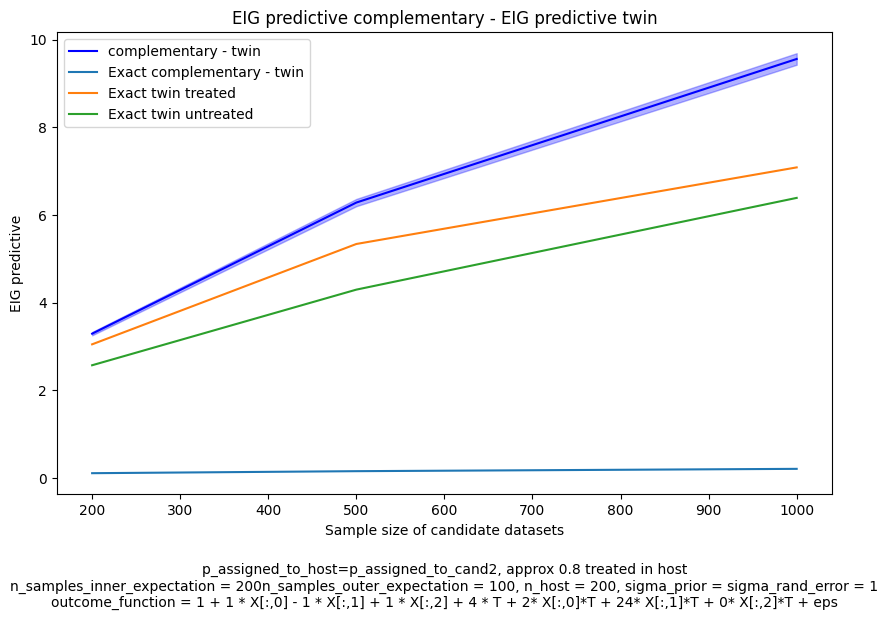

In [18]:
# path_obs_closed_form = '/Users/lucile/causal_info_gain/plots/eig_obs_closed_form'
path_obs_closed_form = 0
alpha = 0.3

plot_array(dict_additional_plots_obs_closed_from, n_both_candidates_list, EIG_obs_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG predictive complementary - EIG predictive twin', save=path_obs_closed_form)

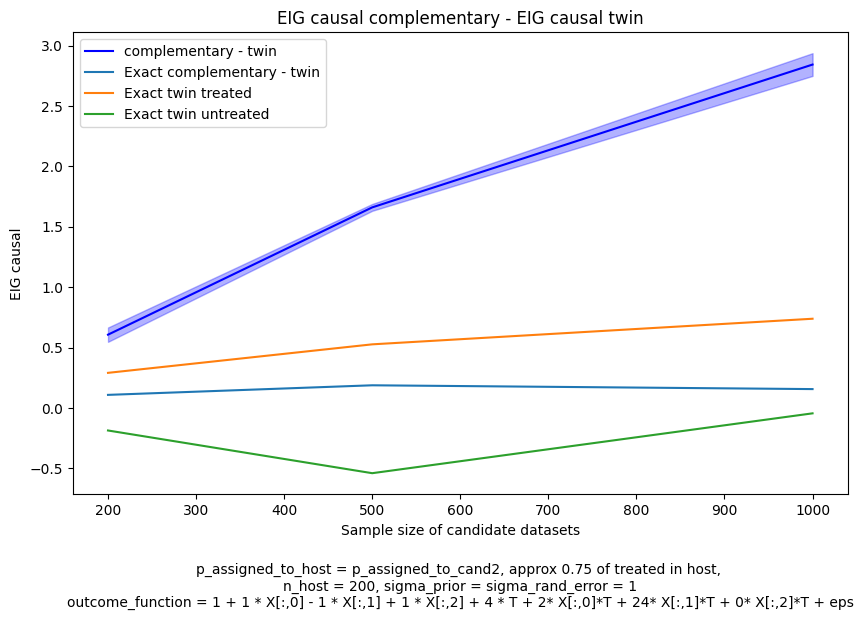

In [11]:
# path_caus_closed_form = '/Users/lucile/causal_info_gain/plots/eig_caus_closed_form'
path_caus_closed_form = 0
alpha = 0.3

plot_array(dict_additional_plots_caus_closed_from, n_both_candidates_list, EIG_caus_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG causal complementary - EIG causal twin', save=path_caus_closed_form)

### 2. EIG from samples for varying sample sizes

In [12]:
n_samples_outer_expectation = 100
n_samples_inner_expectation = 200
n_causal_outer_exp = 100
n_causal_inner_exp = 200

sampling_parameters = {'n_samples_inner_expectation':n_samples_inner_expectation, 'n_samples_outer_expectation':n_samples_outer_expectation, \
                       'n_causal_inner_exp':n_causal_inner_exp, 'n_causal_outer_exp':n_causal_outer_exp}

In [13]:
plot_additional = True
if not plot_additional:
    dict_additional_plots_obs_from_samples = dict_additional_plots_caus_from_samples = {'complementary':0, 'twin': 0, 'twin_treated': 0, 'twin_untreated': 0}

else:
    dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = linear_eig_from_samples_exact_datasets(exact_data, data_parameters, prior_hyperparameters, n_mc, sampling_parameters)
    

In [19]:
n_seeds = 10
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range (n_seeds):
    EIG_obs_samples, EIG_caus_samples = linear_eig_from_samples_varying_sample_size(data, data_parameters, prior_hyperparameters, sampling_parameters)
    if len(EIG_obs_samples_across_seeds)==0:
        EIG_obs_samples_across_seeds= EIG_obs_samples
        EIG_caus_samples_across_seeds = EIG_caus_samples
    else:
        EIG_obs_samples_across_seeds = np.vstack((EIG_obs_samples_across_seeds, EIG_obs_samples))
        EIG_caus_samples_across_seeds = np.vstack((EIG_caus_samples_across_seeds, EIG_caus_samples))

In [15]:
text_l1 ='p_assigned_to_host=p_assigned_to_cand2, approx 0.8 treated in host'
text_l2 = 'n_samples_inner_expectation = '+str(n_samples_inner_expectation)+ 'n_samples_outer_expectation = '+str(n_samples_outer_expectation)+', n_host = '+str(n_host)+', sigma_prior = sigma_rand_error = '+str(sigma_rand_error)
text_l4 = 'n_host = 200, sigma_prior = sigma_rand_error = 1, n_causal_inner_exp = '+str(n_causal_inner_exp) 

plot_additional = 0

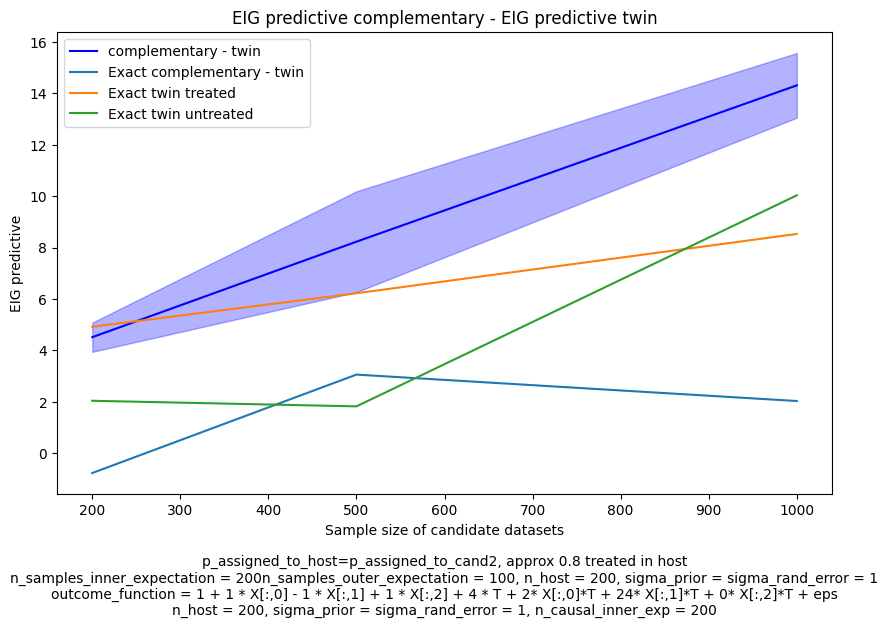

In [16]:
# path_obs_samples = '/Users/lucile/causal_info_gain/plots/eig_obs_samples'
path_obs_samples = 0
alpha = 0.3

plot_array(dict_additional_plots_obs_from_samples, n_both_candidates_list, EIG_obs_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG predictive complementary - EIG predictive twin', save=path_obs_samples)

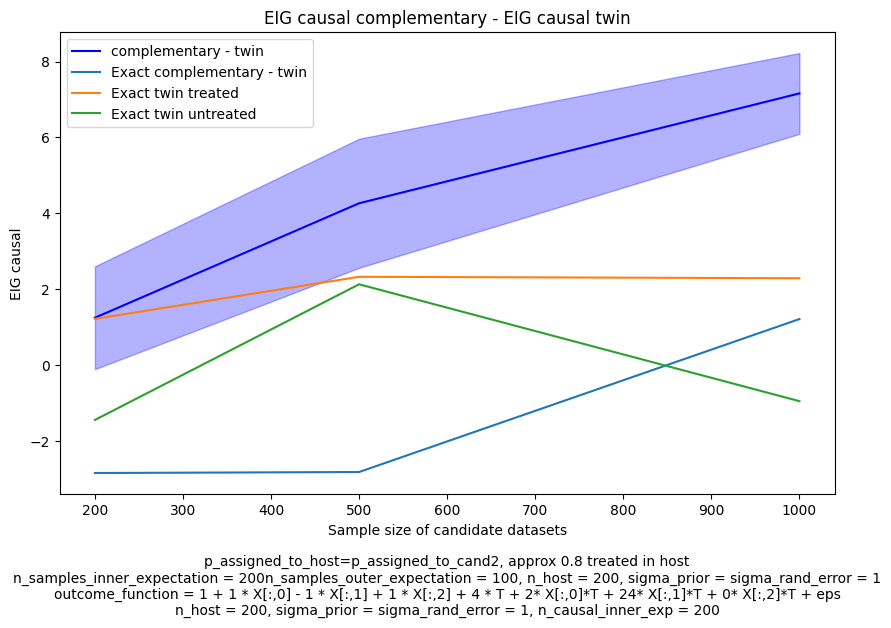

In [17]:
# path_caus_samples = '/Users/lucile/causal_info_gain/plots/eig_caus_samples'
path_caus_samples = 0
alpha = 0.3

plot_array(dict_additional_plots_caus_from_samples, n_both_candidates_list, EIG_caus_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG causal complementary - EIG causal twin', save=path_caus_samples)